In [1]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from __future__ import print_function

In [2]:
def diff_numpy(a, b, msg=None):
    """Shows differences between two tensors"""
    if a.shape != b.shape:
        print('Wrong shape!')
        print(a.shape)
        print(b.shape)
    else:
        diff = (np.sum(a - b))**2
        if msg:
            print('%s diff = %1.6f' % (msg, diff.item()))
        else:
            print('diff = %1.6f' % diff.item())


def images2batches(images):
    """Converts images to convenient for batching form"""
    ndata, img_size, _ = images.shape
    return np.reshape(images, (ndata, img_size*img_size))


def imshow(img):
    """Show image using matplotlib"""
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

def init_uniform(a):
    """Makes iniform initialization of weight matrix (please, use
    numpy.random.uniform function or similar"""
    r_size, c_size = a.shape[0], a.shape[1],
    r = np.sqrt(6/(r_size+c_size))
    return np.array([ np.random.uniform(-r,r) for x in range(r_size*c_size)]).reshape(r_size,c_size)

def relu(m):
    """Implements ReLU activation function"""
    return np.maximum(m, 0)

def drelu(m):
    """Implements ReLU activation function derivative"""
    return np.where(m > 0, 1.0, 0.0)


def get_random_batch(batches_train, batch_size):
    """Outputs random batch of batch_size"""
    (col, _) = batches_train.shape
    indices = np.random.choice(col, batch_size )
    return batches_train[indices]


def get_loss(Y_batch, X_batch_train):
    """Claculates sum squared loss"""
    return np.sum((Y_batch - X_batch_train)**2)

In [3]:
BATCH_SIZE = 20
UPDATES_NUM = 1000
IMG_SIZE = 15
D = 225 # IMG_SIZE*IMG_SIZE
P = 75 # D /// 3
LEARNING_RATE = 0.001

In [4]:
class EncDecNetLite():
    def __init__(self):
        super(EncDecNetLite, self).__init__()
        self.w_in = np.zeros((P, D))
        self.b_in = np.zeros((1, P))      
        #
        # Please, add other weights here
        #
        self.b_rec = np.zeros((1, P))
        self.b_out = np.zeros((1, D))
        self.w_rec = np.zeros((P, P))
        self.w_link = np.zeros((P, P))
        self.w_out = np.zeros((D, P))


    def init(self):
        self.w_in = init_uniform(self.w_in)
        #
        # Please, add initializations of other weights here
        #
        self.w_link = init_uniform(self.w_link)
        self.w_out = init_uniform(self.w_out)
        np.fill_diagonal(self.w_rec,1)

    def scalar_forward(self, x):
      z_in_scalar = np.zeros((BATCH_SIZE, P))
      for i in range(BATCH_SIZE): 
        for j in range(P): 
          temp = 0
          for k in range(D): 
             temp += x[i,k]*self.w_in[j,k]           
          z_in_scalar[i,j]=relu(temp + self.b_in[0,j])
        
        return z_in_scalar

    def vector_forward(self, x):
        B_in = np.matmul(np.ones((BATCH_SIZE, 1)),
                         self.b_in.reshape(1, P)) # [20, 75]
        a_in = np.matmul(x, self.w_in.transpose()) + B_in # [20, 75]        
        z_in_vector = relu(a_in)

        return z_in_vector  
        
    def forward(self, x):
        batch_size = x.shape[0]
        B_in = np.matmul(np.ones((batch_size, 1)),
                         self.b_in.reshape(1, P)) # [20, 75]
        a_in = np.matmul(x, self.w_in.transpose()) + B_in # [20, 75]
        z_in = relu(a_in)
        #
        # Please, add forward pass here
        #
        x_reduce = x[:, range(0, D, 3)] # [20, 75]
        z_link = np.matmul(x_reduce, self.w_link.transpose())

        B_rec = np.matmul(np.ones((batch_size, 1)),
                self.b_rec.reshape(1, P)) # [20, 75]
        a_rec = np.matmul(z_in, self.w_rec.transpose()) + B_rec # [20, 75]
        z_rec = relu(a_rec)

        z_rec_link = z_link + z_rec
        B_out = np.matmul(np.ones((batch_size, 1)),
                self.b_out.reshape(1, D)) # [20, 75]
        a_out = np.matmul(z_rec_link, self.w_out.transpose()) + B_out # [20, 75]
        y = relu(a_out)

        # return y
        return y, a_out, z_rec_link, x_reduce, a_rec, a_in


    def backprop(self, X, Y, a_out, z_rec_link, x_reduce, a_rec, a_in):
        #
        # Please, add backpropagation pass here
        #
        vec = np.ones((BATCH_SIZE,1)).transpose()
        dY = (Y-X) * drelu(a_out) # [20, 225]
        dW_out = np.matmul(dY.transpose(), z_rec_link) # [225, 75]
        dB_out = np.matmul(vec, dY) 
        dOut = np.matmul(dY, self.w_out)

        dZ_link = dOut
        dW_link = np.matmul(dZ_link.transpose(), x_reduce)

        dZ_rec = dOut * drelu(a_rec)

        #Out
        dRec = np.matmul(dZ_rec, self.w_rec)
        
        dZ_in = dRec * drelu(a_in)
        dW_in = np.matmul(dZ_in.transpose(), X)
        dB_in = np.matmul(vec, dZ_in) 
        return dW_out, dB_out, dW_link, dW_in, dB_in

    def apply_dw(self, dW_out, dB_out, dW_link, dW_in, dB_in):
        #
        # Correct neural network''s weights
        #
        self.w_out -= LEARNING_RATE * dW_out
        self.b_out -= LEARNING_RATE * dB_out
        self.w_link -= LEARNING_RATE * dW_link
        self.w_in -= LEARNING_RATE * dW_in
        self.b_in -= LEARNING_RATE * dB_in

In [5]:
# Load train data
images_train = pickle.load(open('images_train.pickle', 'rb'))
# Convert images to batching-friendly format
batches_train = images2batches(images_train)

# Create neural network
neural_network = EncDecNetLite()
# Initialize weights
neural_network.init()

In [11]:
def get_time_vector_forward():
    start_time = time.time()
    for i in range(500):
      X_batch_train = get_random_batch(batches_train, BATCH_SIZE)
      X_batch_train = X_batch_train/255
      res = neural_network.vector_forward(X_batch_train)
    end_time = time.time()
    return end_time-start_time

def get_time_scalar_forward():
    start_time = time.time()
    for i in range(500):
      X_batch_train = get_random_batch(batches_train, BATCH_SIZE)
      X_batch_train = X_batch_train/255
      res = neural_network.scalar_forward(X_batch_train)
    end_time = time.time()
    return end_time-start_time

In [14]:
print("\nLayer_in comparison in vector and scalar forms:")
print("\nTime of 500 iterartions for vector form :", get_time_vector_forward())
print("\nTime of 500 iterartions for scalar form :", get_time_scalar_forward())


Layer_in comparison in vector and scalar forms:

Time of 500 iterartions for vector form : 0.1084134578704834

Time of 500 iterartions for scalar form : 5.171440362930298


In [8]:
loss = np.zeros(UPDATES_NUM)
for i in range(UPDATES_NUM):
   # Get random batch for Stochastic Gradient Descent
   X_batch_train = get_random_batch(batches_train, BATCH_SIZE)
   X_batch_train = X_batch_train/255

   # Forward pass, calculate network''s outputs
  #  y, a_out, z_rec_link, x_reduce, a_rec, a_in
   y, a_out, z_rec_link, x_reduce, a_rec, a_in = neural_network.forward(X_batch_train)
        
   # Calculate sum squared loss
   loss[i] = get_loss(y, X_batch_train)

   if (i%50 == 0):
      print(f'Loss: {loss[i]}')
   # Backward pass, calculate derivatives of loss w.r.t. weights
   dW_out, dB_out, dW_link, dW_in, dB_in = neural_network.backprop(X_batch_train, y, a_out, z_rec_link, x_reduce, a_rec, a_in)

   # Correct neural network''s weights
   neural_network.apply_dw(dW_out, dB_out, dW_link, dW_in, dB_in)


Loss: 179.95888020908546
Loss: 62.08681155773729
Loss: 38.67026960241233
Loss: 29.992135638557258
Loss: 32.42852939354012
Loss: 14.752889930612985
Loss: 22.698953013783033
Loss: 11.566638257124575
Loss: 16.67163700907638
Loss: 15.058485255193668
Loss: 12.988431159141353
Loss: 8.649047726127943
Loss: 14.003534586672233
Loss: 12.58137825937273
Loss: 8.224886501397727
Loss: 7.259539713995717
Loss: 9.442303651530349
Loss: 9.027947915996165
Loss: 10.876741714517312
Loss: 7.597822350700299


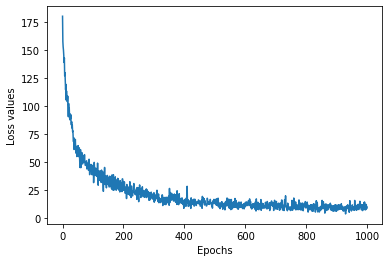

In [9]:
plt.plot(loss)
plt.ylabel('Loss values')
plt.xlabel('Epochs')
plt.show()

Test data


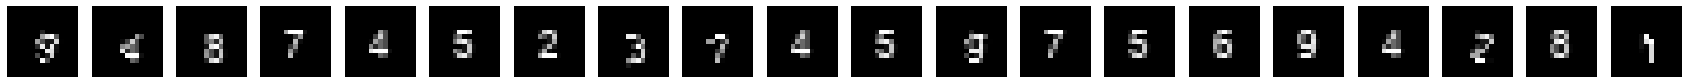

Predicted data


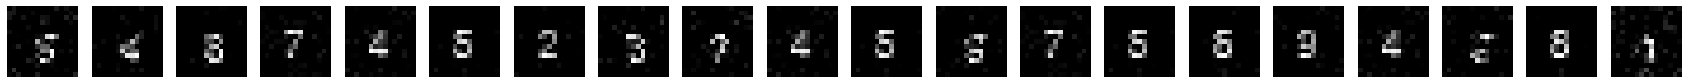

In [26]:
images_test = pickle.load(open('images_test.pickle', 'rb'))
# Convert images to batching-friendly format
X_batch_test = images2batches(images_test)
y, a_out, z_rec_link, x_reduce, a_rec, a_in = neural_network.forward(X_batch_test)
print('Test data')
plt.figure(figsize=(30,15))
for i in range(20):
  plt.subplot(1, 20, i+1)
  plt.imshow(images_test[i], plt.get_cmap('gray'))
  plt.axis('off')
plt.show()
print('Predicted data')
plt.figure(figsize=(30,15))
for i in range(20):
  plt.subplot(1, 20, i+1)
  plt.imshow(255*y[i].reshape(15,15), plt.get_cmap('gray'))
  plt.axis('off')
plt.show()